In [1]:
import pandas as pd
import regex as re

from sklearn.model_selection import train_test_split

import ahocorasick

import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration, get_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW, lr_scheduler

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
SEP_TOKEN = '▁<extra_id_0>'
INPUT_PREFIX = ''

In [3]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  


In [4]:
def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    # Фильтрация
    #text = re.sub ('[“”]', '\"', text)

    # Создаем регулярное выражение для разделителей
    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    
    # Разделяем текст на абзацы
    #paragraphs = text.split ('\n')
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    # Список для хранения предложений и их индексов
    sentences_with_segments = []
    
    current_start_index = 0
    # Обрабатываем каждый абзац
    for paragraph in paragraphs:
        # Разделяем абзац на предложения
        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        #print (f'\nРассматривается параграф: <{paragraph}>.')
        
        # Сопоставляем предложения с сегментами
        for sentence in sentences:
            #print ('> Предложение:', sentence)
            # Ищем индексы символов для текущего предложения
            start_index = current_start_index
            end_index = start_index + len (sentence)

            #print (f'Current sentence (from split): <{sentence}>')
            #print (f'Current sentence (by indices): <{text [start_index: end_index]}>')
            #print (f'Sentence start index: {start_index}, end index: {end_index}.')
            #print (f'Segments to match: {segments}')

            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            #current_start_index += len (sentence) + MAGIC_NUMBER
            current_start_index = end_index


            #print ('Термины:', matched_segments)
    
    return sentences_with_segments

In [5]:
#train_data_txt, temp_data_txt, train_labels_txt, temp_labels_txt = train_test_split (df ['text'], df ['label'], test_size = 0.2, random_state = 14)
#val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (temp_data_txt, temp_labels_txt, test_size = 0.5, random_state = 14)

train_data_txt = df ['text']
train_labels_txt = df ['label']

In [6]:
def label_constructor (labels):
    res = []
    for label in labels:
        one_label = []
        for start, end, cls in label:
            one_label.append ([start, end])
        res.append (one_label)
    return res

In [7]:
df_2 = pd.read_json ('./test_data/test1_t12_full_v2.jsonl', lines = True)
df_2 = df_2 [['text', 'label']]
print (df_2.head ())

                                                text  \
0  АВТОМАТИЧЕСКИЙ АНАЛИЗ ТОНАЛЬНОСТИ ТЕКСТОВ НА О...   
1  InBASE: ТЕХНОЛОГИЯ ПОСТРОЕНИЯ ЕЯ-ИНТЕРФЕЙСОВ К...   
2  Выражение уважительности с помощью личных мест...   
3  ДА ЧЕРТ ЛИ В ДЕТАЛЯХ?.. МЕРА ДЛЯ ОЦЕНКИ СОВПАД...   
4  КОРПУСНАЯ ОЦЕНКА СОЧЕТАЕМОСТИ СЛОВ С ИСПОЛЬЗОВ...   

                                               label  
0  [[0, 33, specific], [22, 33, specific], [52, 7...  
1  [[0, 6, nomen], [19, 44, specific], [30, 44, s...  
2  [[0, 24, specific], [35, 53, specific], [42, 5...  
3  [[51, 70, specific], [61, 70, specific], [116,...  
4  [[0, 16, specific], [17, 34, specific], [30, 3...  


In [8]:
val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (df_2 ['text'], df_2 ['label'], test_size = 0.5, random_state = 14)

#val_data_txt = df_2 ['text']
#val_labels_txt = df_2 ['label']

#test_data_txt = val_data_txt
#test_labels_txt = val_labels_txt

In [9]:
train_data_lst = train_data_txt.tolist ()
train_labels_lst = train_labels_txt.tolist ()

parallel_text = []
parallel_label = []

for i in range (len (train_data_lst)):
    text = train_data_lst [i]
    segments = train_labels_lst [i]
    splitted = split_text (text, segments)
    for sentence, terms in splitted:
        parallel_text.append (INPUT_PREFIX + sentence)
        constructed_label = ''
        for term in terms:
            constructed_label += term.strip () + SEP_TOKEN
        if len (constructed_label) > 0:
            parallel_label.append (constructed_label [: - len (SEP_TOKEN)])
        else:
            parallel_label.append ('')


val_data_lst = val_data_txt.tolist ()
val_labels_lst = label_constructor (val_labels_txt)
parallel_text_val = []
parallel_label_val = []
for i in range (len (val_data_lst)):
    text = val_data_lst [i]
    segments = val_labels_lst [i]
    splitted = split_text (text, segments)
    for sentence, terms in splitted:
        parallel_text_val.append (INPUT_PREFIX + sentence)
        constructed_label = ''
        for term in terms:
            constructed_label += term.strip () + SEP_TOKEN
        if len (constructed_label) > 0:
            parallel_label_val.append (constructed_label [: - len (SEP_TOKEN)])
        else:
            parallel_label_val.append ('')


test_data_lst = test_data_txt.tolist ()
test_labels_lst = label_constructor (test_labels_txt)
parallel_text_test = []
parallel_label_test = []
for i in range (len (test_data_lst)):
    text = test_data_lst [i]
    segments = test_labels_lst [i]
    splitted = split_text (text, segments)
    for sentence, terms in splitted:
        parallel_text_test.append (INPUT_PREFIX + sentence)
        constructed_label = ''
        for term in terms:
            constructed_label += term.strip () + SEP_TOKEN
        if len (constructed_label) > 0:
            parallel_label_test.append (constructed_label [: - len (SEP_TOKEN)])
        else:
            parallel_label_test.append ('')

In [10]:
USED_MODEL_NAME = 'cointegrated/rut5-small'#'ai-forever/rut5-base'#'cointegrated/rut5-small'

SEQ_MAX_LENGTH = 150
BATCH_SIZE = 8
EVAL_BATCH_SIZE = 32

ENABLE_LABEL_FIX = True

In [11]:
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [12]:
train_data = tokenizer (parallel_text, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
train_labels = tokenizer (parallel_label, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

val_data = tokenizer (parallel_text_val, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (parallel_text_test, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (parallel_label_test, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

In [13]:
### EXPERIMENTAL SOMETHING

def replace_padding (labels):
    for i in range (0, len (labels ['input_ids'])):
        labels ['input_ids'] [i] = torch.tensor ([labl if labl != 0 else - 100 for labl in labels ['input_ids'] [i]])

    return labels

if ENABLE_LABEL_FIX:
    rse = replace_padding (train_labels)
    train_labels = rse

    rse = replace_padding (val_labels)
    val_labels = rse

    rse = replace_padding (test_labels)
    test_labels = rse

train_labels ['input_ids']
###

tensor([[  298,   452,   452,  ...,  -100,  -100,  -100],
        [ 6527,  1626,  6414,  ...,  -100,  -100,  -100],
        [ 7592, 17096,  5446,  ...,  -100,  -100,  -100],
        ...,
        [ 9102,   685, 20099,  ...,  -100,  -100,  -100],
        [ 9102,   685, 20099,  ...,  -100,  -100,  -100],
        [ 5416,  7368,   685,  ...,  -100,  -100,  -100]])

In [14]:
class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

train_dataset = Seq2SeqDataset (train_data, train_labels)
val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

In [15]:
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)
#model.train ()


cuda:0


In [16]:
def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != - 100]   ### WHAT?!
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [17]:
metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

In [18]:
num_epochs = 50
training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
warmup_steps = int (training_steps * 0.1)
print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

Suggested train steps: 26150
	 warmup steps: 1307 - 2615


In [19]:
#from fairseq.optim.adafactor import Adafactor

In [20]:
#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 5e-5, weight_decay = 0.02)

#optimizer = Adafactor (model.parameters (), lr = 3e-5, scale_parameter = False, relative_step = False, weight_decay = 0.02)

#scheduler = lr_scheduler.StepLR (optimizer, warmup_steps = 637, training_steps = 6375)
scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = warmup_steps, num_training_steps = training_steps)

In [ ]:
for epoch in range (num_epochs):
    model.train ()
    total_loss = 0
    
    for batch in tqdm (train_loader):
        
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)

        outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss
        total_loss += loss.item ()

        loss.backward ()
        optimizer.step ()
        optimizer.zero_grad ()

        scheduler.step ()

        torch.cuda.empty_cache ()
    

    avg_loss = total_loss / len (train_loader)

    metrics ['train_loss'].append ((epoch, avg_loss))

    model.eval ()
    val_preds, val_labels = [], []
    total_val_loss = 0

    with torch.no_grad ():
        for batch in val_loader:
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels = batch ['labels'].to (model.device)

            outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length = SEQ_MAX_LENGTH)

            total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels).loss.item ()

            val_preds.extend (outputs)
            val_labels.extend (labels)

            torch.cuda.empty_cache ()

    avg_val_loss = total_val_loss / len (val_loader)

    prec, recl, f1sc = sanity_check (val_preds, val_labels)

    metrics ['val_loss'].append ((epoch, avg_val_loss))
    metrics ['precision'].append ((epoch, prec))
    metrics ['recall'].append ((epoch, recl))
    metrics ['f1_score'].append ((epoch, f1sc))

    print (f'Epoch {epoch + 1} / {num_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')

100%|██████████| 523/523 [01:07<00:00,  7.76it/s]


Epoch 1 / 50, Loss: 3.0875, Validation loss: 2.1267, 0.010954616588419406 / 0.0029276453366792136 / 0.0046204620462046205


100%|██████████| 523/523 [01:07<00:00,  7.77it/s]


Epoch 2 / 50, Loss: 1.7003, Validation loss: 1.2214, 0.3789308176100629 / 0.30238393977415307 / 0.33635729239357987


100%|██████████| 523/523 [01:07<00:00,  7.79it/s]


Epoch 3 / 50, Loss: 1.0996, Validation loss: 0.9133, 0.46500920810313073 / 0.4224173985780008 / 0.4426912119219811


100%|██████████| 523/523 [01:07<00:00,  7.79it/s]


Epoch 4 / 50, Loss: 0.8781, Validation loss: 0.7591, 0.47972142564522735 / 0.48975324132162273 / 0.48468543046357615


100%|██████████| 523/523 [01:07<00:00,  7.76it/s]


Epoch 5 / 50, Loss: 0.7531, Validation loss: 0.6676, 0.5324204591220298 / 0.5529067335842743 / 0.5424702503077554


100%|██████████| 523/523 [01:09<00:00,  7.58it/s]


Epoch 6 / 50, Loss: 0.6527, Validation loss: 0.6134, 0.5698969072164949 / 0.5780008364700961 / 0.573920265780731


100%|██████████| 523/523 [01:05<00:00,  7.98it/s]


Epoch 7 / 50, Loss: 0.5819, Validation loss: 0.5859, 0.5630185697352825 / 0.5959849435382685 / 0.5790329134498171


100%|██████████| 523/523 [01:06<00:00,  7.92it/s]


Epoch 8 / 50, Loss: 0.5296, Validation loss: 0.5659, 0.5673040869891264 / 0.6327896277708072 / 0.5982601818900751


100%|██████████| 523/523 [01:05<00:00,  7.97it/s]


Epoch 9 / 50, Loss: 0.4978, Validation loss: 0.5494, 0.5811065111027475 / 0.6457549142618152 / 0.6117274167987322


100%|██████████| 523/523 [01:05<00:00,  7.98it/s]


Epoch 10 / 50, Loss: 0.4585, Validation loss: 0.5395, 0.5949464012251149 / 0.6499372647427855 / 0.6212272636418149


100%|██████████| 523/523 [01:05<00:00,  7.95it/s]


Epoch 11 / 50, Loss: 0.4340, Validation loss: 0.5406, 0.6122994652406417 / 0.67043078209954 / 0.6400479137552407


100%|██████████| 523/523 [01:05<00:00,  7.94it/s]


Epoch 12 / 50, Loss: 0.4075, Validation loss: 0.5194, 0.6156773211567732 / 0.6767043078209954 / 0.6447499501892807


100%|██████████| 523/523 [01:26<00:00,  6.06it/s]


Epoch 13 / 50, Loss: 0.3821, Validation loss: 0.5312, 0.6056644880174292 / 0.6976160602258469 / 0.648396501457726


100%|██████████| 523/523 [01:25<00:00,  6.11it/s]


Epoch 14 / 50, Loss: 0.3636, Validation loss: 0.5119, 0.6268088347296268 / 0.6884148891677122 / 0.6561690253139326


100%|██████████| 523/523 [01:21<00:00,  6.39it/s]


Epoch 15 / 50, Loss: 0.3487, Validation loss: 0.5043, 0.6333841463414634 / 0.6951066499372648 / 0.6628115653040878


100%|██████████| 523/523 [01:24<00:00,  6.16it/s]


Epoch 16 / 50, Loss: 0.3308, Validation loss: 0.5061, 0.625421822272216 / 0.6976160602258469 / 0.6595492289442467


100%|██████████| 523/523 [01:26<00:00,  6.06it/s]


Epoch 17 / 50, Loss: 0.3193, Validation loss: 0.5248, 0.6238632229901783 / 0.7172731074864074 / 0.6673151750972762


100%|██████████| 523/523 [01:26<00:00,  6.04it/s]


Epoch 18 / 50, Loss: 0.3056, Validation loss: 0.5190, 0.6369114877589453 / 0.7072354663320787 / 0.6702338485929449


100%|██████████| 523/523 [01:26<00:00,  6.07it/s]


Epoch 19 / 50, Loss: 0.2935, Validation loss: 0.5172, 0.6377456433073786 / 0.7193642827268926 / 0.6761006289308177


100%|██████████| 523/523 [01:27<00:00,  5.97it/s]


Epoch 20 / 50, Loss: 0.2831, Validation loss: 0.5166, 0.6452816113390526 / 0.7235466332078628 / 0.6821766561514196


100%|██████████| 523/523 [01:25<00:00,  6.08it/s]


Epoch 21 / 50, Loss: 0.2725, Validation loss: 0.5193, 0.6459840121811953 / 0.7097448766206608 / 0.6763650856915105


100%|██████████| 523/523 [01:26<00:00,  6.05it/s]


Epoch 22 / 50, Loss: 0.2641, Validation loss: 0.5146, 0.6566008517228029 / 0.7093266415725638 / 0.68194611982308


100%|██████████| 523/523 [01:25<00:00,  6.08it/s]


Epoch 23 / 50, Loss: 0.2553, Validation loss: 0.5222, 0.6527514231499051 / 0.7193642827268926 / 0.6844409072821329


100%|██████████| 523/523 [01:25<00:00,  6.08it/s]


Epoch 24 / 50, Loss: 0.2458, Validation loss: 0.5304, 0.6654874213836478 / 0.7080719364282727 / 0.6861195542046605


100%|██████████| 523/523 [01:25<00:00,  6.12it/s]


Epoch 25 / 50, Loss: 0.2367, Validation loss: 0.5313, 0.648689138576779 / 0.7243831033040569 / 0.6844497134953567


100%|██████████| 523/523 [01:26<00:00,  6.04it/s]


Epoch 26 / 50, Loss: 0.2339, Validation loss: 0.5281, 0.6592115238817285 / 0.7273107486407361 / 0.6915887850467289


100%|██████████| 523/523 [01:26<00:00,  6.06it/s]


Epoch 27 / 50, Loss: 0.2298, Validation loss: 0.5342, 0.6529389741669787 / 0.7294019238812213 / 0.6890557092058475


100%|██████████| 523/523 [01:27<00:00,  6.01it/s]


Epoch 28 / 50, Loss: 0.2203, Validation loss: 0.5367, 0.6633397312859884 / 0.7227101631116688 / 0.6917534027221778


100%|██████████| 523/523 [01:26<00:00,  6.05it/s]


Epoch 29 / 50, Loss: 0.2122, Validation loss: 0.5361, 0.6564485981308411 / 0.7344207444583856 / 0.693249111725227


100%|██████████| 523/523 [01:25<00:00,  6.12it/s]


Epoch 30 / 50, Loss: 0.2080, Validation loss: 0.5487, 0.6634725948639325 / 0.7239648682559598 / 0.6923999999999999


100%|██████████| 523/523 [01:25<00:00,  6.12it/s]


Epoch 31 / 50, Loss: 0.2038, Validation loss: 0.5446, 0.6695481335952849 / 0.71267252195734 / 0.6904376012965964


100%|██████████| 523/523 [01:25<00:00,  6.09it/s]


Epoch 32 / 50, Loss: 0.1989, Validation loss: 0.5462, 0.6532227666792311 / 0.7248013383521539 / 0.6871530531324346


100%|██████████| 523/523 [01:25<00:00,  6.10it/s]


Epoch 33 / 50, Loss: 0.1974, Validation loss: 0.5477, 0.6649016641452344 / 0.7352572145545797 / 0.6983118172790468


100%|██████████| 523/523 [01:26<00:00,  6.05it/s]


Epoch 34 / 50, Loss: 0.1930, Validation loss: 0.5424, 0.6669190007570023 / 0.7369301547469678 / 0.70017881978939


100%|██████████| 523/523 [01:26<00:00,  6.04it/s]


Epoch 35 / 50, Loss: 0.1841, Validation loss: 0.5446, 0.6636871508379888 / 0.7452948557089084 / 0.702127659574468


100%|██████████| 523/523 [01:25<00:00,  6.10it/s]


Epoch 36 / 50, Loss: 0.1881, Validation loss: 0.5465, 0.6648023862788963 / 0.7457130907570054 / 0.7029371180760892


100%|██████████| 523/523 [01:25<00:00,  6.12it/s]


Epoch 37 / 50, Loss: 0.1806, Validation loss: 0.5503, 0.6634072959759308 / 0.7377666248431619 / 0.6986138613861387


100%|██████████| 523/523 [01:26<00:00,  6.04it/s]


Epoch 38 / 50, Loss: 0.1749, Validation loss: 0.5602, 0.6657804785415875 / 0.7331660393140945 / 0.6978503184713376


100%|██████████| 523/523 [01:26<00:00,  6.08it/s]


Epoch 39 / 50, Loss: 0.1738, Validation loss: 0.5650, 0.6660253943824548 / 0.7239648682559598 / 0.6937875751503005


100%|██████████| 523/523 [01:26<00:00,  6.03it/s]


Epoch 40 / 50, Loss: 0.1748, Validation loss: 0.5602, 0.6640271493212669 / 0.7365119196988708 / 0.6983938132064247


100%|██████████| 523/523 [01:07<00:00,  7.73it/s]


Epoch 41 / 50, Loss: 0.1710, Validation loss: 0.5612, 0.6741922927209031 / 0.7243831033040569 / 0.6983870967741935


100%|██████████| 523/523 [01:07<00:00,  7.77it/s]


Epoch 42 / 50, Loss: 0.1650, Validation loss: 0.5670, 0.6612062546537603 / 0.7427854454203262 / 0.6996257632460114


100%|██████████| 523/523 [01:08<00:00,  7.68it/s]


Epoch 43 / 50, Loss: 0.1686, Validation loss: 0.5604, 0.6699695121951219 / 0.7352572145545797 / 0.7010967098703889


100%|██████████| 523/523 [01:08<00:00,  7.61it/s]


Epoch 44 / 50, Loss: 0.1651, Validation loss: 0.5663, 0.6694592536176694 / 0.7352572145545797 / 0.70081722144708


100%|██████████| 523/523 [01:07<00:00,  7.73it/s]


Epoch 45 / 50, Loss: 0.1639, Validation loss: 0.5691, 0.6681904761904762 / 0.7335842743621915 / 0.6993620414673046


100%|██████████| 523/523 [01:08<00:00,  7.67it/s]


Epoch 46 / 50, Loss: 0.1641, Validation loss: 0.5657, 0.669717772692601 / 0.7344207444583856 / 0.7005784959106324


100%|██████████| 523/523 [01:07<00:00,  7.76it/s]


Epoch 47 / 50, Loss: 0.1581, Validation loss: 0.5681, 0.6720492118415994 / 0.7310748640736093 / 0.7003205128205128


100%|██████████| 523/523 [01:07<00:00,  7.69it/s]


Epoch 48 / 50, Loss: 0.1585, Validation loss: 0.5658, 0.6694592536176694 / 0.7352572145545797 / 0.70081722144708


100%|██████████| 523/523 [01:08<00:00,  7.68it/s]


Epoch 49 / 50, Loss: 0.1575, Validation loss: 0.5665, 0.6730548102721349 / 0.7344207444583856 / 0.7024


100%|██████████| 523/523 [01:07<00:00,  7.78it/s]


Epoch 50 / 50, Loss: 0.1566, Validation loss: 0.5660, 0.6729294478527608 / 0.7340025094102886 / 0.702140428085617


https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/T5/Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code.ipynb#scrollTo=wvRHDkCIS91f

In [22]:
print (metrics)

{'train_loss': [(0, 3.0874712305360723), (1, 1.700324310513345), (2, 1.0995646295766301), (3, 0.8780810852921488), (4, 0.7531400204958469), (5, 0.6526570924723354), (6, 0.5819162791363368), (7, 0.5295563934808936), (8, 0.49779626308276137), (9, 0.45850771676969804), (10, 0.4340041124512999), (11, 0.4074567449537336), (12, 0.3821053830176649), (13, 0.3635964482224922), (14, 0.3486956973091822), (15, 0.33082643507429565), (16, 0.3193204110883618), (17, 0.3056272228834278), (18, 0.29349507871538), (19, 0.28309215811823796), (20, 0.272491741733159), (21, 0.2640540968790565), (22, 0.25531286132267283), (23, 0.2457577466081479), (24, 0.23670896493169136), (25, 0.23394733098964163), (26, 0.2298152833521708), (27, 0.22029571599873712), (28, 0.21224788762985178), (29, 0.2079860913864627), (30, 0.20377491373233997), (31, 0.1989167892083839), (32, 0.19736089338023166), (33, 0.19298615640681058), (34, 0.18412455946321013), (35, 0.18814742782404273), (36, 0.18062537768232434), (37, 0.17493127110497

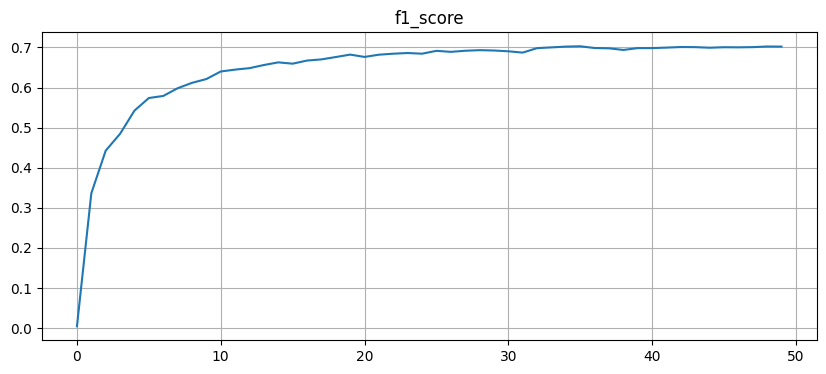

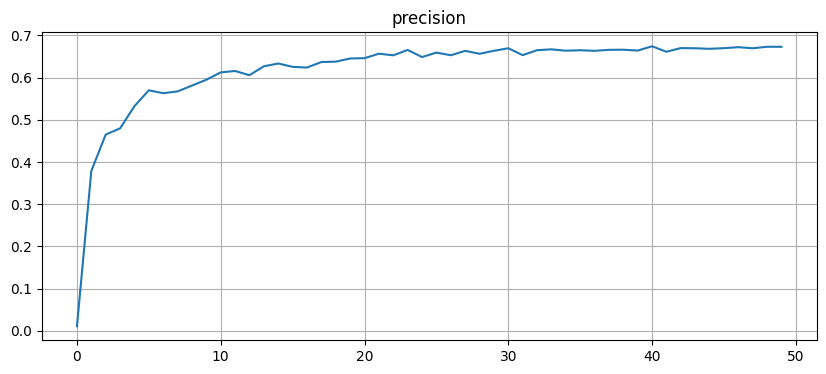

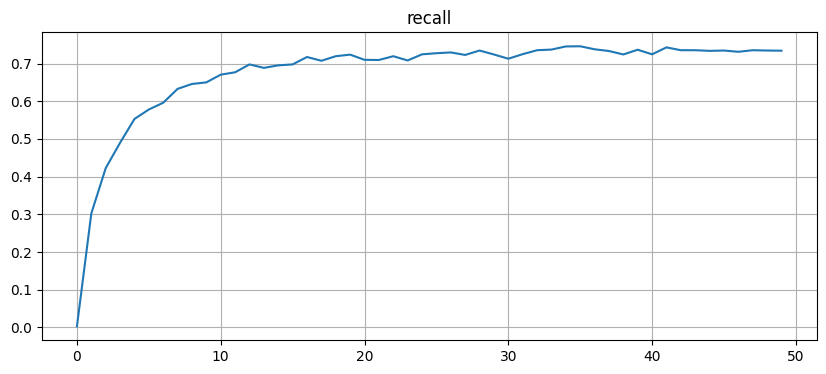

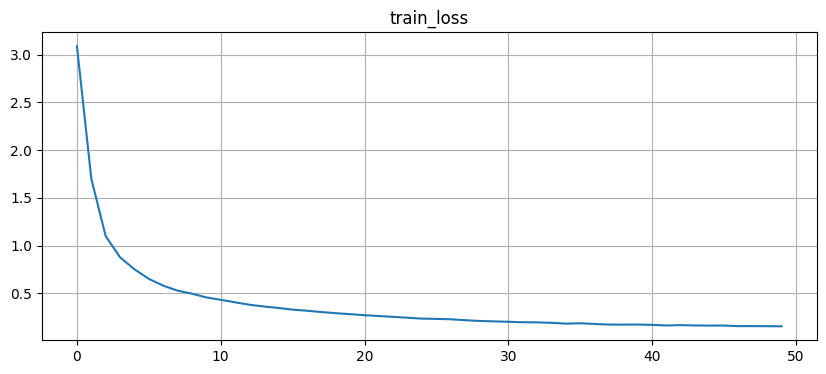

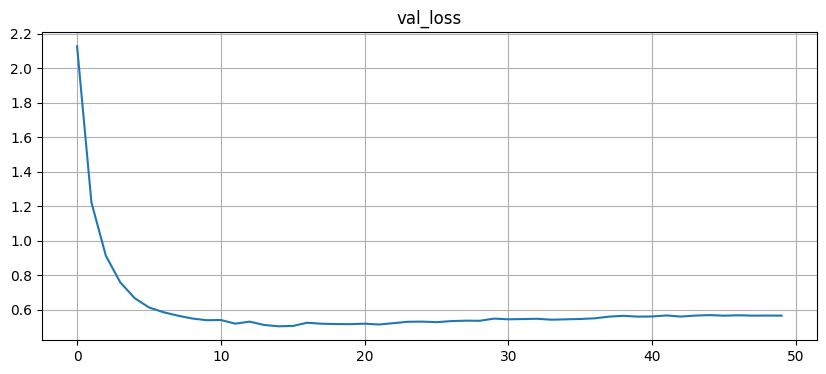

In [23]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [24]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model (input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        outputs = outputs.logits.argmax(-1)

        #print (outputs)
        print (tokenizer.batch_decode (labels))
        print (tokenizer.batch_decode (outputs))

        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        print (sanity_check (outputs, labels, to_print = True))

        break

OverflowError: can't convert negative int to unsigned

In [25]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

        torch.cuda.empty_cache ()

    print ('Validation: ', sanity_check (val_preds, val_labels))


val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

        torch.cuda.empty_cache ()

    print ('Test: ', sanity_check (val_preds, val_labels))

100%|██████████| 19/19 [00:03<00:00,  4.85it/s]


Validation:  (0.6281628162816282, 0.47762442492680884, 0.5426467094321692)


100%|██████████| 22/22 [00:04<00:00,  4.81it/s]


Test:  (0.6396308887809616, 0.5017142857142857, 0.5623398804440649)


In [26]:

val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=170)

        val_preds.extend (out)
        val_labels.extend (labels)

        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels))


val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=170)

        val_preds.extend (out)
        val_labels.extend (labels)

        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels))

100%|██████████| 19/19 [00:11<00:00,  1.62it/s]


Validation wmax:  (0.6724137931034483, 0.7340025094102886, 0.7018596280743852)


100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


Test wmax:  (0.6964164976335362, 0.7847619047619048, 0.7379545047465521)


In [ ]:
#model.save_pretrained('./coint_rut5small_finetune_fulltrain_novalid')
#tokenizer.save_pretrained('./coint_rut5small_finetune_fulltrain_novalid')

In [ ]:
def raw_splitter (text, delimiters = ['...', '.', '?!', '?', '!']):

    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    sentences_with_indices = []
    current_start_index = 0

    for paragraph in paragraphs:

        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        for sentence in sentences:

            start_index = current_start_index
            end_index = start_index + len (sentence)

            sentences_with_indices.append ((sentence, (start_index, end_index)))

            current_start_index = end_index
    
    return sentences_with_indices

def one_finder (text, phrases):

    A = ahocorasick.Automaton ()
    
    for idx, phrase in enumerate (phrases):
        A.add_word (phrase, (idx, phrase))
    
    A.make_automaton ()
    
    found = []
    for end_index, (idx, phrase) in A.iter (text):
        start_index = end_index - len (phrase) + 1

        if start_index > 0 and text [start_index - 1].isalpha ():
            continue
        if end_index + 1 < len (text) and text [end_index + 1].isalpha ():
            continue

        found.append ((start_index, end_index + 1, phrase))
    
    return found

def answerer (text, term_set):
    sentences_w_ind = raw_splitter (text)

    answers = []
    for sentence, (start, end) in sentences_w_ind:
        found = one_finder (sentence, term_set)
        answers += [[item [0] + start, item [1] + start] for item in found]

    return answers

def comparator (pred, labl):

    pred = set ([tuple (item) for item in pred])
    labl = set ([tuple (item) for item in labl])

    true_positives = len (pred & labl)
    false_positives = len (pred - labl)
    false_negatives = len (labl - pred)

    return true_positives, false_positives, false_negatives

def metricator (preds, labels):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):

        true_positives, false_positives, false_negatives = comparator (preds [i], labels [i])

        tps_sum += true_positives   # Истинно положительные
        fps_sum += false_positives     # Ложноположительные
        fns_sum += false_negatives     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score